# Import modules + define routines & EPICS channels

In [1]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import multiprocessing as mp
num_cores = mp.cpu_count()
print(num_cores)

24


In [2]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        #Position = BS_file[channel_laser_pitch][:][reprate_FEL]
        Palm = BS_file[channel_palm_analysis][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped, Palm

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [3]:
# only through raw and JF

channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_waveplate= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
channel_laser_yaw= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


In [36]:
# #For BS local

# channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_Izero = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
# channel_Izero2 = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
# channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
# channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
# channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
# channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
# #channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
# channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
# channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
# channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
# channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
# channel_waveplate= "SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
# channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

# #Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
# channel_position = "SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
# channel_position = "SLAAR11-LMOT-M451:ENC_1_BS/data"
# channel_energy = "SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
# channel_laser_yaw= "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
# channel_laser_pitch= "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
# channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


# Scan name

In [33]:
 scan_name ="CytC_Fe3_monoscan_288nm_5uJ_500fs_009"
#scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_004"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

# Analyse full run

In [134]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 2.1T
drwxrwsr-x. 72 root p17803 4.0K Jan 25 16:23 ..
-rw-r--r--.  1 root p17803  36G Jan 25 16:26 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803  12M Jan 25 16:26 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 16:28 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 25 16:28 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803  12M Jan 25 16:29 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 16:31 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803  36G Jan 25 16:31 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803  12M Jan 25 16:32 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 1.7G Jan 25 16:33 CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0002.BSREAD.h5
-r

ra-c-002.psi.ch
There are 127 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/


In [135]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
Signal_diff = []
err_signal_pump = []
err_signal_unpump = []
err_signal_diff = []

SignalT_pump = []
SignalT_unpump = []
err_signalT_pump = []

Izero_pump = []
Izero_unpump = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

Palm_fs = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=5:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        
        threshold_pump = Izero_pump_loop > 1000
        threshold_unpump = Izero_unpump_loop > 1000 
        condition_pump = Izero_pump_loop > np.median(Izero_pump_loop)-1.2*(np.std(Izero_pump_loop))
        condition_unpump = Izero_unpump_loop > np.median(Izero_unpump_loop)-1.2*(np.std(Izero_unpump_loop))

        signal_pump_loop = signal_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_pump_loop = Izero_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_unpump_loop = signal_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_unpump_loop = Izero_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        signal_unpump_loop_norm = signal_unpump_loop / Izero_unpump_loop
        signal_diff_loop = signal_unpump_loop / Izero_unpump_loop
        
        Signal_pump.append(signal_pump_loop_norm.mean())
        Signal_unpump.append(signal_unpump_loop_norm.mean())
        Signal_diff.append(signal_diff_loop.mean())
        
        
        #Signal_pump.append(np.mean(signal_pump_loop))
        #Signal_unpump.append(signal_unpump_loop.mean())
        #err_signal_pump.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        #err_signal_unpump.append(signal_unpump_loop.std()/np.sqrt(signal_unpump_loop.size))
        
        #signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        
        err_signal_pump.append(signal_pump_loop_norm.std()/np.sqrt(signal_pump_loop_norm.size))
        err_signal_unpump.append(signal_unpump_loop_norm.std()/np.sqrt(signal_unpump_loop_norm.size))
        err_signal_diff.append(signal_diff_loop.std()/np.sqrt(signal_diff_loop.size))
        
        #Izero_pump.append(Izero_pump_loop.mean())
        #Izero_unpump.append(Izero_unpump_loop.mean())
        #err_Izero_pump.append(Izero_pump_loop.std()/np.sqrt(Izero_pump_loop.size))
        #err_Izero_unpump.append(Izero_unpump_loop.std()/np.sqrt(Izero_unpump_loop.size))
        
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT_pump.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        Palm_fs.append(np.mean(palm_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size,np.mean(position_loop))
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
Signal_diff = np.asarray(Signal_diff)

err_signal_pump = np.asarray(err_signal_pump)
err_signal_unpump = np.asarray(err_signal_unpump)
err_signal_diff = np.asarray(err_signal_diff)

err_signal_pump_relative = np.asarray(err_signal_pump)/Signal_pump
err_signal_unpump_relative = np.asarray(err_signal_unpump)/Signal_unpump

SignalT_pump = np.asarray(SignalT_pump)
SignalT_unpump = np.asarray(SignalT_unpump)
err_signalT_pump = np.asarray(err_signalT_pump)

Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
Palm_fs =np.asarray(Palm_fs)
Delay_ps = (Position_mm - 150.365)*2/(3e8*1e3*1e-12) # change to right t0 !
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_scan_info.json
Processing 56 files
step 1 of 56 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0000.BSREAD.h5
1707 1707 150.3769989712128
step 2 of 56 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0001.BSREAD.h5
1836 1836 150.37700092108798
step 3 of 56 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0002.BSREAD.h5
1800 1800 150.377001171072
step 4 of 56 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0003.BSREAD.h5
1712 1712 150.3769956214272
step 5 of 56 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_288nm_5uJ_500fs_009/CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0004.BSRE

1894 1894 150.3770007211008
Job done!


In [136]:
Signal_pump_norm = Signal_pump #/ Izero_pump
Signal_unpump_norm = Signal_unpump #/ Izero_unpump

SignalT_pump_norm = SignalT_pump #/ Izero_pump
SignalT_unpump_norm = SignalT_unpump #/ Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_pump_norm = err_signal_pump #/ Izero_pump
err_signal_unpump_norm = err_signal_unpump #/ Izero_unpump

#err_signal_pump_relative_norm = err_signal_pump_relative / Izero_pump
#err_signal_unpump_relative_norm = err_signal_unpump_relative / Izero_unpump

#err_signalT_norm = err_signalT_pump / Izero_pump

In [84]:
# Optional to run --> it returns the maximum value of the trace
#m=max(Signal_pump_norm-Signal_unpump_norm)
#print(m)
#[i for i, j in enumerate(Signal_pump_norm-Signal_unpump_norm) if j==m] # returns the location in x axis indexes of the max
#print(Energy_eV[15])
#print(Position_mm)

# Plot Energy Scans

<IPython.core.display.Javascript object>


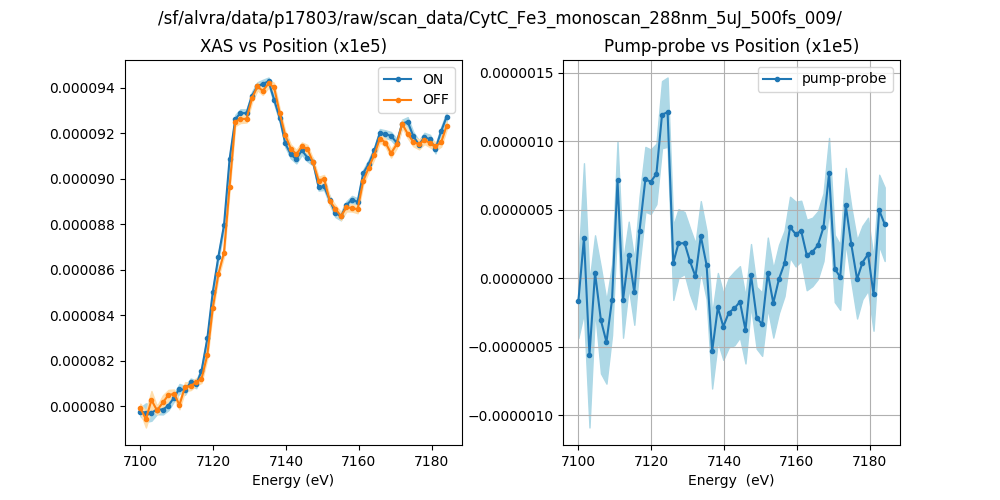

In [137]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

#low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - err_signal_pump_relative_norm
#high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + err_signal_unpump_relative_norm

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")



#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

#plt.savefig('Timescan_7_diode')

# Plot Energy Scans

<IPython.core.display.Javascript object>


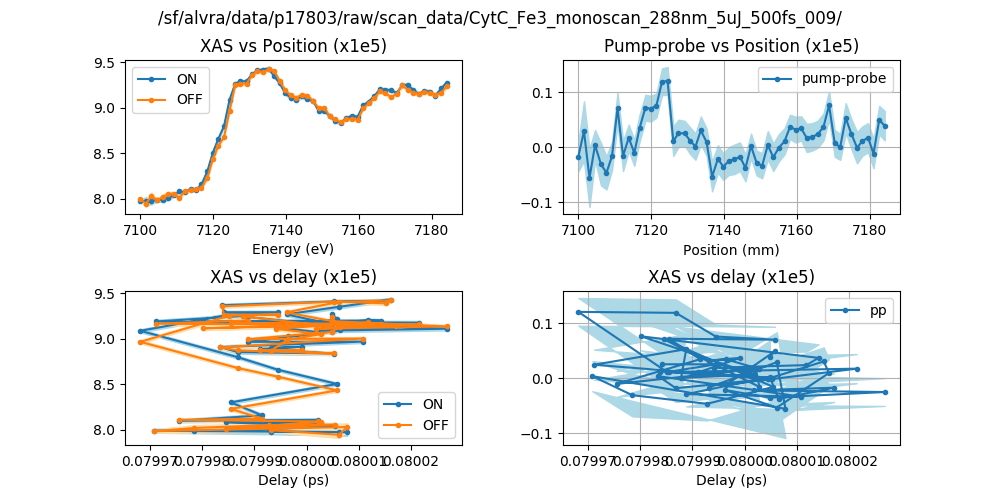

In [138]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

plt.subplot(2,2,1)
plt.plot(Energy_eV, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,2)
plt.plot(Energy_eV, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")

plt.subplot(2,2,3)
plt.plot(Delay_ps, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Delay_ps, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")

plt.subplot(2,2,4)
plt.plot(Delay_ps, scale*(Signal_pump_norm-Signal_unpump_norm), label="pp",marker='.')
plt.fill_between(Delay_ps, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')


#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show()

# save the pp sig and its xaxis into a variable name after the scan name. 
# This is convenient to compare different scans together, see cell below.
x = scan_name + "_DIFF"
t = scan_name + "_ENERGY"
vars()[x] = (Signal_pump_norm-Signal_unpump_norm)
vars()[t] = Energy_eV

#plt.savefig('Timescan_7_diode')


# Compare runs

In [94]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def exp(x, baseline, amplitude, t0, width, a1, t1):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [ ]:
def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [75]:

# Here we import the traces analyzed and saved from scan 10, 11, 12 XES pink beam


LOADDIR = "/das/work/p17/p17803/Processed_files/"
h5f = h5py.File(LOADDIR + 'Scan_13_XES_CytCFe3','r') 

xscan12 = h5f['Delay_mm'][:]
yscan12 = h5f['XAS_transient'][:]
RIXS_scan12=h5f['RIXS_transient'][:]

xaxis3= xscan12
yaxis3= yscan12


h5f.close()


In [77]:
#xaxis3
yaxis3

array([0.05418828, 0.07222868, 0.04978763, 0.07906526, 0.04117942,
       0.06428686, 0.05791133, 0.0741015 , 0.08880246, 0.10324013,
       0.09495677, 0.11234891, 0.11718009, 0.10950522, 0.10616913,
       0.10325436, 0.08549943, 0.13335531, 0.11602932, 0.10324401,
       0.09877209, 0.1010398 , 0.10729136, 0.09377784, 0.09189736,
       0.09575992, 0.10197718, 0.08188895, 0.11357181, 0.07076162,
       0.08193029, 0.10311367, 0.07599642, 0.06045301, 0.06816752,
       0.07211583, 0.08294102, 0.07236304, 0.07330193, 0.05067967,
       0.06769534, 0.0770248 , 0.06325302, 0.06043335, 0.07942987,
       0.07876514, 0.07841864, 0.06812449, 0.05775933, 0.05196969])

<IPython.core.display.Javascript object>


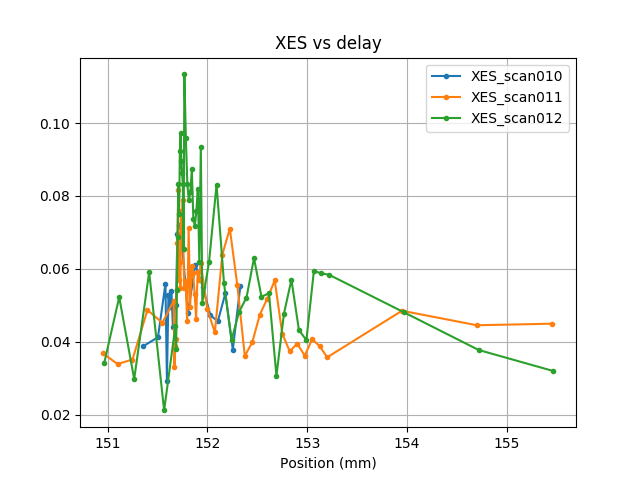

<IPython.core.display.Javascript object>


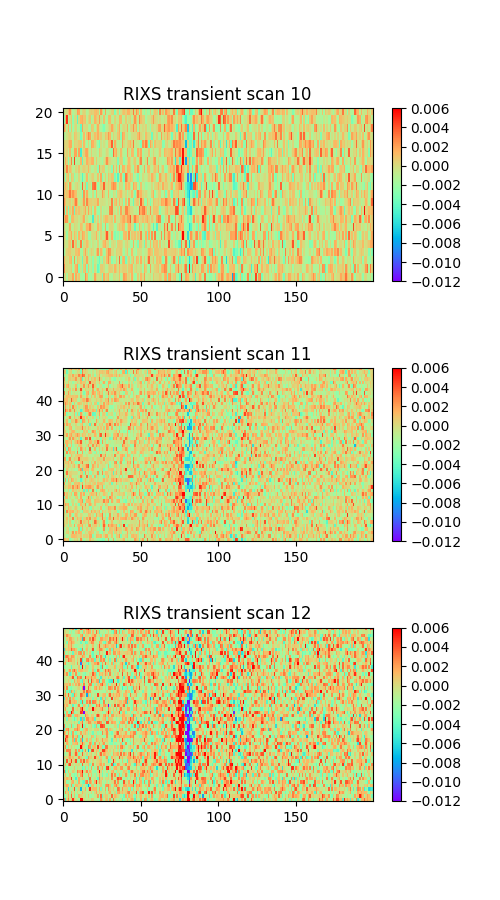

In [78]:
from scipy.interpolate import interp1d
from scipy import interpolate

#scan_003
#xaxis1=CytC_Fe3_monoscan_288nm_5uJ_500fs_003_ENERGY
#yaxis1=CytC_Fe3_monoscan_288nm_5uJ_500fs_003_DIFF
#xaxis1=[7.0999181e+03,7.1013764e+03,7.1030331e+03,7.1045572e+03,7.1059666e+03,7.1074322e+03,7.1088932e+03,7.1105595e+03,7.1121280e+03,7.1136099e+03,7.1151319e+03,7.1165733e+03,7.1184027e+03,7.1196847e+03,7.1213208e+03,7.1224877e+03,7.1242681e+03,7.1254417e+03,7.1270597e+03,7.1286257e+03,7.1298282e+03,7.1316934e+03,7.1333554e+03,7.1342899e+03,7.1359322e+03,7.1374752e+03,7.1394084e+03,7.1401625e+03,7.1420717e+03,7.1436873e+03,7.1451157e+03,7.1463926e+03,7.1479234e+03,7.1497030e+03,7.1513461e+03,7.1528708e+03,7.1542845e+03,7.1556807e+03,7.1570795e+03,7.1585974e+03,7.1602520e+03]
#yaxis1=[-1.9134378e-07,-8.1099039e-09,-1.9927280e-07,-1.3413764e-07,-1.1672675e-07,-5.6609369e-08,8.1398039e-08,-2.7308265e-07,   3.5765525e-08, -1.8050104e-07,  -8.0189736e-08,   3.9199099e-07,   2.6110790e-07,   4.4687650e-07,   6.0496241e-07,   7.4803189e-07,   4.5132581e-07,   4.8132913e-07,  -5.1537449e-08,   3.0002461e-07,  -1.6243802e-07,   9.8634199e-08,  -1.8298163e-07,  -8.5109079e-08,  -3.2551587e-08,  -2.8902684e-07,  -1.8625463e-07,  -1.8007653e-08,  -5.0568468e-07,   1.6500351e-09,  -3.0506208e-07,  -3.3865709e-08,  -8.1796705e-08,  -3.6593988e-07,  -3.2594529e-07,  -2.7086045e-07,  -3.2631443e-07,  -8.5283804e-08,   1.1052036e-07,   2.8118394e-07,   1.2519718e-07]


#scan_009
#xaxis2=CytC_Fe3_monoscan_288nm_5uJ_500fs_009_ENERGY
#yaxis2=CytC_Fe3_monoscan_288nm_5uJ_500fs_009_DIFF

#xaxis2=[ 7.1001992e+03,   7.1020993e+03,   7.1030749e+03,   7.1045272e+03,   7.1064129e+03,   7.1077614e+03,   7.1092084e+03,   7.1110259e+03,   7.1125416e+03,   7.1140791e+03,   7.1153805e+03,   7.1171453e+03,   7.1185035e+03,   7.1200346e+03,   7.1216574e+03,   7.1231066e+03,   7.1247286e+03,   7.1259701e+03,   7.1272340e+03,   7.1294861e+03,   7.1307450e+03,  7.1322746e+03,   7.1339016e+03,   7.1355192e+03,   7.1368142e+03,   7.1384868e+03,   7.1398354e+03,   7.1413688e+03,   7.1428109e+03,   7.1446135e+03,   7.1458711e+03,   7.1475900e+03,   7.1492060e+03,   7.1503763e+03,   7.1522300e+03,   7.1536222e+03,   7.1552472e+03,   7.1571416e+03,   7.1584073e+03,   7.1598926e+03,   7.1612896e+03,   7.1627277e+03,   7.1643048e+03,   7.1657922e+03,   7.1674162e+03,   7.1687746e+03,   7.1704738e+03,   7.1717790e+03,   7.1735452e+03,   7.1748012e+03,   7.1765084e+03,   7.1777718e+03,   7.1793945e+03,   7.1811912e+03,   7.1825535e+03,   7.1843534e+03]
#yaxis2=[-3.3136000e-07,   3.1775210e-08,  -6.5217081e-07,  -1.6800351e-07,  -4.4079547e-07,  -5.7142289e-07,  -3.2356690e-07,  3.7578249e-07,  -3.2736933e-07,  -6.4142420e-08,  -2.8314697e-07,  7.4222928e-08,   3.8163597e-07,   3.6052083e-07,   4.1241352e-07,   7.5537040e-07,   7.7364156e-07,  -1.0242423e-07,   1.2864723e-08,   5.2068473e-09,  -9.8524434e-08,  -1.8304017e-07,   5.3290607e-08, -1.2440371e-07,  -6.2582908e-07,  -3.6163993e-07,  -4.8458243e-07,  -4.0195114e-07,  -3.7119415e-07,  -3.3851160e-07,  -5.0084040e-07,  -1.8093504e-07,  -4.2875425e-07,  -4.6908602e-07,  -1.6550948e-07,  -3.5185204e-07,  -2.0197662e-07,  -9.0522553e-08,  1.0737929e-07,   5.7445159e-08,   8.0516688e-08,  -6.7400722e-08,  -4.4327030e-08,  -1.2088821e-10,   1.0172378e-07,   4.1682174e-07,  -1.3839320e-07,  -1.9025073e-07,   2.3244099e-07,  -1.9339409e-09,  -2.0076070e-07,  -1.0756590e-07,  -5.9515674e-08,  -2.8812042e-07,   2.0180948e-07,   1.1537576e-07]


#xaxis2SORTED = sorted(xaxis2)
#sortindices2=np.argsort(xaxis2)
#yaxis2original=yaxis2
#yaxis2=yaxis2[sortindices2]



# We plot traces together
plt.figure()
plt.plot(xaxis1, yaxis1, label="XES_scan010",marker='.')
plt.plot(xaxis2+0.06, yaxis2, label="XES_scan011",marker='.')
plt.plot(xaxis3+0.07, yaxis3-0.02, label="XES_scan012",marker='.')
plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('XES vs delay')
plt.legend(loc="best")
plt.show()


plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)
plt.subplot(311)
plt.imshow(RIXS_scan10, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("RIXS transient scan 10")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_scan11, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("RIXS transient scan 11")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_scan12, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("RIXS transient scan 12")
plt.colorbar()
plt.show()


In [ ]:
xaxis2new=xaxis2+0.06
xaxis3new=xaxis3+0.07

<IPython.core.display.Javascript object>


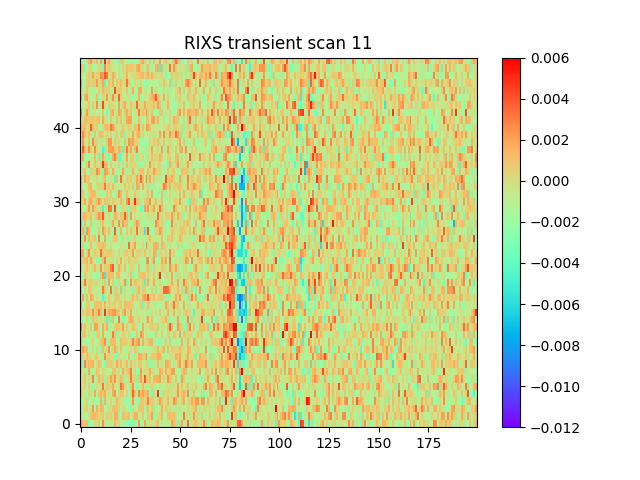

<IPython.core.display.Javascript object>


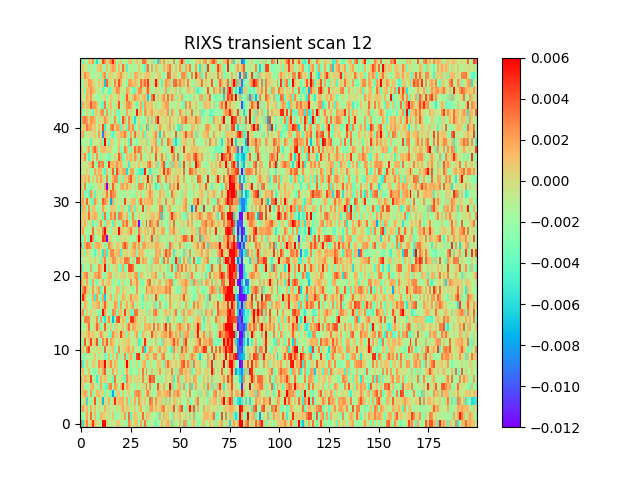

<IPython.core.display.Javascript object>


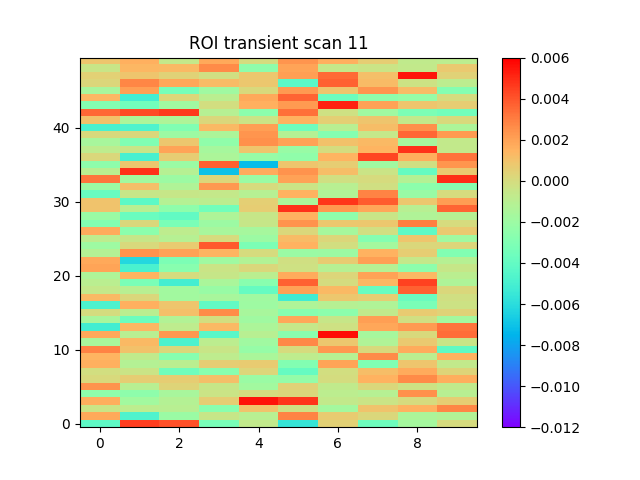

<IPython.core.display.Javascript object>


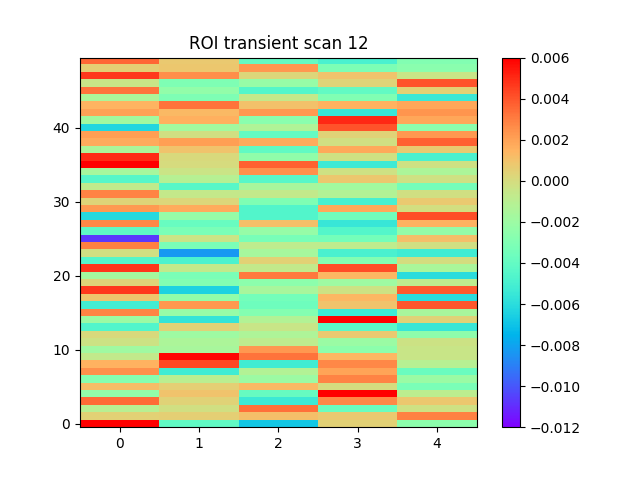

<IPython.core.display.Javascript object>


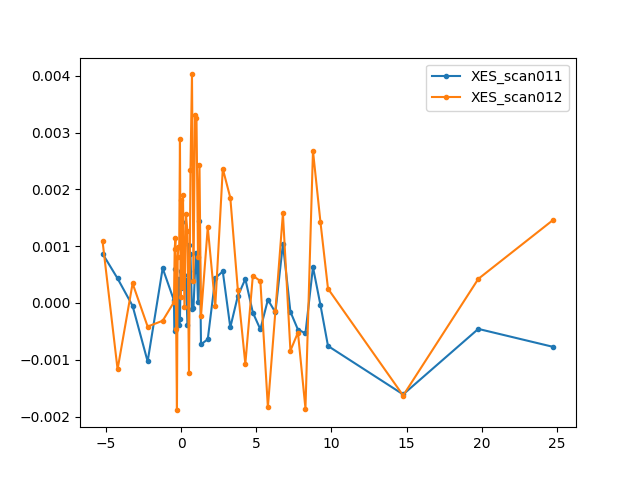

<IPython.core.display.Javascript object>


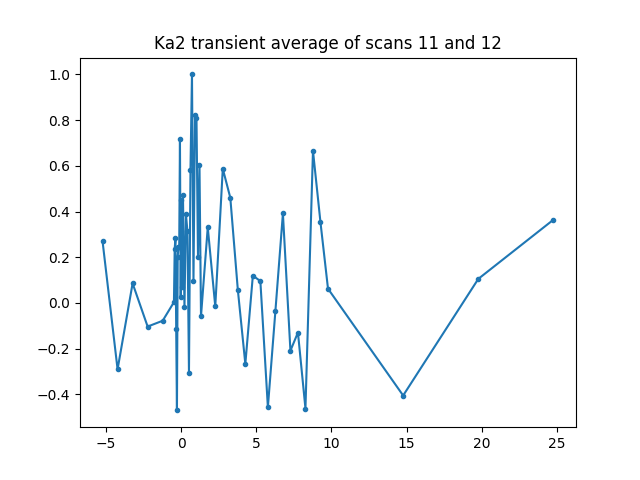

Text(0.5,1,'Ka2 transient average of scans 11 and 12')

In [192]:
#xscan12

Ka2_11 = RIXS_scan11[0:50, 110:120]
Ka2_12 = RIXS_scan12[0:50, 110:115]

plt.figure()
plt.imshow(RIXS_scan11, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("RIXS transient scan 11")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(RIXS_scan12, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("RIXS transient scan 12")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(Ka2_11, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("ROI transient scan 11")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(Ka2_12, aspect = 'auto', cmap = "rainbow", origin ="lower", vmin=-0.012, vmax=0.006)
plt.title("ROI transient scan 12")
plt.colorbar()
plt.show()



ka2_12sum = -Ka2_12.mean(axis=1)
ka2_11sum = -Ka2_11.mean(axis=1)
timeps = (xscan12 - 151.68)*2/(3e8*1e3*1e-12) # change to right t0 !


plt.figure()
plt.plot(timeps,ka2_11sum-0.0001, label="XES_scan011",marker='.')
plt.plot(timeps,ka2_12sum, label="XES_scan012",marker='.')
plt.legend(loc="best")


ka211_norm=ka2_11sum/np.max(ka2_11sum)
ka212_norm=ka2_12sum/np.max(ka2_12sum)



#y_ave=(ynew1+ynew2)/2
y_ave_ka2=(ka212_norm+ka212_norm)/2
#y_ave=(ynew2_norm+ynew3_norm)/2


plt.figure()
plt.plot(timeps,y_ave_ka2, label="XES_scan011",marker='.')
plt.title("Ka2 transient average of scans 11 and 12")





Parameters for interpolated data
Position t0 = 0.066 ps
Width = 0.002 ps
a1 = 1.913
t1 = 318080.298 ps
a2 = 6.01
t2 = 1.429 ps


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<IPython.core.display.Javascript object>


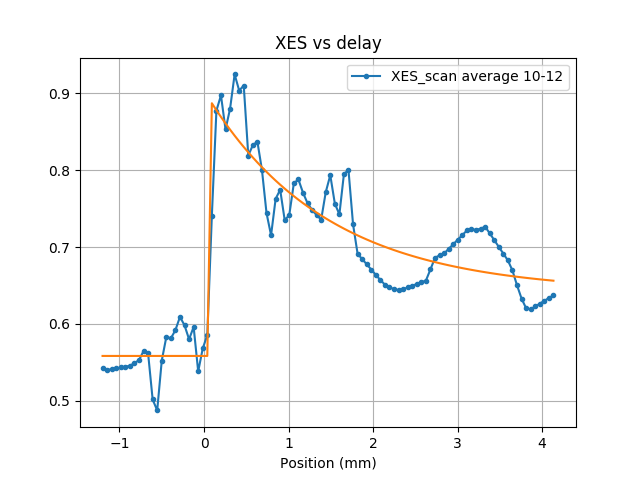

In [132]:
y1 = yaxis1
x1 = xaxis1
f1 = interp1d(x1, y1, kind='linear')

y2 = yaxis2
x2 = xaxis2new
f2 = interp1d(x2, y2, kind='linear')

y3 = yaxis3
x3 = xaxis3new
f3 = interp1d(x3, y3, kind='linear')

#linear interpolation
xnew = np.linspace(151.5, 152.3, num=100, endpoint=True)
ynew1=f1(xnew)
ynew2=f2(xnew)
ynew3=f3(xnew)


ynew1_norm=ynew1/np.max(ynew1)
ynew2_norm=ynew2/np.max(ynew2)
ynew3_norm=ynew3/np.max(ynew3)



#y_ave=(ynew1+ynew2)/2
y_ave=(ynew1_norm+ynew2_norm+ynew3_norm)/3
#y_ave=(ynew2_norm+ynew3_norm)/2


Delay_ps = (xnew - 151.68)*2/(3e8*1e3*1e-12) # change to right t0 !

# FIT WITH BI EXPONENTIAL

parameters_ave,extras = curve_fit(biexp, Delay_ps, y_ave, p0 = [0.00, 1, 1, 0.1, 0.0001, .5, 5.0, 20.]) # [baseline, step amplitude, center, FWHM]

print("Parameters for interpolated data")
print("Position t0 =",np.abs(np.round(parameters_ave[2],3)),"ps")
print("Width =",np.abs(np.round(parameters_ave[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters_ave[4],3)))
print("t1 =",np.abs(np.round(parameters_ave[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters_ave[6],3)))
print("t2 =",np.abs(np.round(parameters_ave[7],3)),"ps")



plt.figure()
plt.plot(Delay_ps,y_ave, label="XES_scan average 10-12",marker='.')

plt.plot(Delay_ps, biexp(Delay_ps,parameters_ave[0],parameters_ave[1],parameters_ave[2],parameters_ave[3],parameters_ave[4],\
                       parameters_ave[5],parameters_ave[6],parameters_ave[7]))

#plt.plot(x1, y1, 'x')
#plt.plot(x4, y4, 'x')
#plt.plot(x2, y2, 'x')
#plt.plot(x3, y3, 'x')

plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('XES vs delay')
plt.legend(loc="best")
plt.show()


Parameters for interpolated data
Position t0 = 0.345 ps
Width = 0.058 ps
a1 = 0.004
t1 = 3.09 ps


<IPython.core.display.Javascript object>


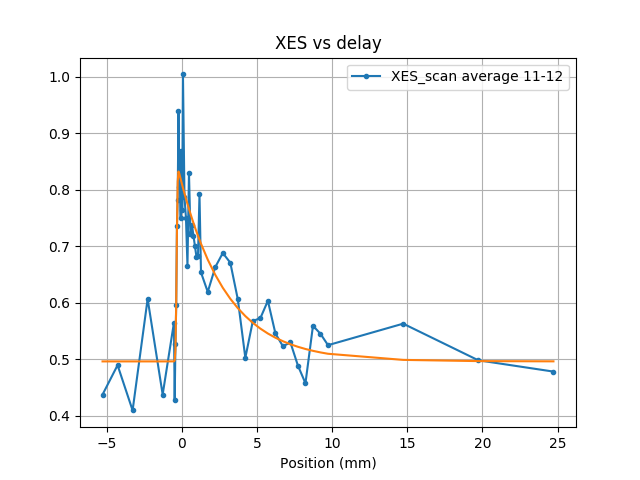

In [148]:
#y1 = yaxis1
#x1 = xaxis1
#f1 = interp1d(x1, y1, kind='linear')

y2 = yaxis2
x2 = xaxis2new
#f2 = interp1d(x2, y2, kind='linear')

y3 = yaxis3
x3 = xaxis3new
#f3 = interp1d(x3, y3, kind='linear')

#linear interpolation
xnew = xaxis2#np.linspace(151, 155, num=100, endpoint=True)
#ynew1=f1(xnew)
#ynew2=f2(xnew)
#ynew3=f3(xnew)


#ynew1_norm=ynew1/np.max(ynew1)
ynew2_norm=y2/np.max(y2)
ynew3_norm=y3/np.max(ynew3)



#y_ave=(ynew1+ynew2)/2
#y_ave=(ynew1_norm+ynew2_norm+ynew3_norm)/3
y_ave=(ynew2_norm+ynew3_norm)/2


Delay_ps = (xnew - 151.68)*2/(3e8*1e3*1e-12) # change to right t0 !

# FIT WITH BI EXPONENTIAL

#parameters_ave,extras = curve_fit(biexp, Delay_ps, y_ave, p0 = [0.00, 1, 1, 0.1, 0.0001, .5, 5.0, 20.]) # [baseline, step amplitude, center, FWHM]

#print("Parameters for interpolated data")
#print("Position t0 =",np.abs(np.round(parameters_ave[2],3)),"ps")
#print("Width =",np.abs(np.round(parameters_ave[3],3)),"ps")
#print("a1 =",np.abs(np.round(parameters_ave[4],3)))
#print("t1 =",np.abs(np.round(parameters_ave[5],3)),"ps")
#print("a2 =",np.abs(np.round(parameters_ave[6],3)))
#print("t2 =",np.abs(np.round(parameters_ave[7],3)),"ps")

# FIT WITH MONO EXPONENTIAL

parameters_ave,extras = curve_fit(exp, Delay_ps, y_ave, p0 = [0.020, 0.8, 1, 0.1, 0.0001,3]) # [baseline, step amplitude, center, FWHM]

print("Parameters for interpolated data")
print("Position t0 =",np.abs(np.round(parameters_ave[2],3)),"ps")
print("Width =",np.abs(np.round(parameters_ave[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters_ave[4],3)))
print("t1 =",np.abs(np.round(parameters_ave[5],3)),"ps")


plt.figure()
plt.plot(Delay_ps,y_ave, label="XES_scan average 11-12",marker='.')

#plt.plot(Delay_ps, biexp(Delay_ps,parameters_ave[0],parameters_ave[1],parameters_ave[2],parameters_ave[3],parameters_ave[4],\
#                       parameters_ave[5],parameters_ave[6],parameters_ave[7]))

plt.plot(Delay_ps, exp(Delay_ps,parameters_ave[0],parameters_ave[1],parameters_ave[2],parameters_ave[3],parameters_ave[4],\
                       parameters_ave[5]))
#plt.plot(x1, y1, 'x')
#plt.plot(x4, y4, 'x')
#plt.plot(x2, y2, 'x')
#plt.plot(x3, y3, 'x')

plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('XES vs delay')
plt.legend(loc="best")
plt.show()

In [21]:
# you have to run the analysis once and the data will be saved in variables scan_name_DELAY and scan_name_DIFF

xaxis1=CytC_Fe3_monoscan_288nm_5uJ_500fs_003_ENERGY
yaxis1=CytC_Fe3_monoscan_288nm_5uJ_500fs_003_DIFF

xaxis2=CytC_Fe3_monoscan_288nm_5uJ_1400fs_005_ENERGY
yaxis2=CytC_Fe3_monoscan_288nm_5uJ_1400fs_005_DIFF

xaxis3=CytC_Fe3_monoscan_288nm_5uJ_7000fs_007_ENERGY
yaxis3=CytC_Fe3_monoscan_288nm_5uJ_7000fs_007_DIFF


xaxis2SORTED = sorted(xaxis2)
sortindices2=np.argsort(xaxis2)
yaxis2original=yaxis2
yaxis2=yaxis2[sortindices2]
#yaxisMODEL = biexp(x,-0.05, 0.1, 0, 0.5, 1, 2., 1, 10.)


plt.figure()
plt.plot(xaxis1, scale*yaxis1, label="scan003",marker='.')
plt.plot(xaxis2, scale*yaxis2, label="scan009",marker='.')

plt.grid()
plt.xlabel("Energy(eV)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")
plt.show()

NameError: name 'CytC_Fe3_monoscan_288nm_5uJ_1400fs_005_ENERGY' is not defined

In [37]:
# Fit of the time traces
parameters1,extras = curve_fit(biexp, xaxis1, scale*yaxis1, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters2,extras = curve_fit(biexp, xaxis2, scale*yaxis2, p0 = [-0.05, 0.1, 0, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters3,extras = curve_fit(biexp, xaxis3, scale*yaxis3, p0 = [-0.0, 0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
parameters4,extras = curve_fit(biexp, xaxis4, scale*yaxis4, p0 = [-0.0, 0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]


print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003")
print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters1[4],3)))
print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters1[6],3)))
print("t2 =",np.abs(np.round(parameters1[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_004")
print("Position t0 =",np.abs(np.round(parameters2[2],3)),"ps")
print("Width =",np.abs(np.round(parameters2[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters2[4],3)))
print("t1 =",np.abs(np.round(parameters2[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters2[6],3)))
print("t2 =",np.abs(np.round(parameters2[7],3)),"ps")

print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_005")
print("Position t0 =",np.abs(np.round(parameters3[2],3)),"ps")
print("Width =",np.abs(np.round(parameters3[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters3[4],3)))
print("t1 =",np.abs(np.round(parameters3[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters3[6],3)))
print("t2 =",np.abs(np.round(parameters3[7],3)),"ps")

plt.figure()
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")
plt.grid()


plt.figure()
plt.subplot(4,1,1)
plt.plot(xaxis1, scale*yaxis1, label="scan_003",marker='.')
plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7]))
plt.legend(loc="best")

plt.subplot(4,1,2)
plt.plot(xaxis2, scale*yaxis2, label="scan_004",marker='.')
plt.plot(xaxis2, biexp(xaxis2,parameters2[0],parameters2[1],parameters2[2],parameters2[3],parameters2[4],\
                       parameters2[5],parameters2[6],parameters2[7]))
plt.legend(loc="best")

plt.subplot(4,1,3)
plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")


plt.subplot(4,1,4)
plt.plot(xaxis4, scale*yaxis4, label="scan_006",marker='.')
plt.plot(xaxis4, biexp(xaxis4,parameters4[0],parameters4[1],parameters4[2],parameters4[3],parameters4[4],\
                       parameters4[5],parameters4[6],parameters4[7]))
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
plt.show()


# Other plots.

#plt.plot(xaxis1 - parameters1[2], biexp(xaxis1 - parameters1[2],parameters1[0],parameters1[1],\
#                 parameters1[2],parameters1[3],parameters1[4],parameters1[5],parameters1[6],parameters1[7]))
#plt.plot(xaxis2 - parameters2[2], biexp(xaxis2 - parameters2[2],parameters2[0],parameters2[1],parameters2[2],\
#                 parameters2[3],parameters2[4],parameters2[5],parameters2[6],parameters2[7]))



#plt.plot(xaxis1 - parameters1[2], yaxis1, label="scan_003",marker='.')
#plt.plot(xaxis2 - parameters2[2], yaxis2, label="scan_004",marker='.')


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


NameError: name 'xaxis4' is not defined

# More stuff

In [18]:
myList = np.concatenate((np.arange(7100,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [560]:
time_zero = 150.188         #this is in mm from the delay scans

desidered_delays = [-10,-1,1]  
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")


T_1 = np.arange(149.4372,150.1872


mtime = np.concatenate((np.arange(149.4372,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [561]:
print(time_zero)

150.295


In [ ]:
desidered_delays = [-10,-1,1]  


In [85]:
Position_mm

delay_ps = (Position_mm - 150.188)*2/(3e8*1e3*1e-12)
print(delay_ps)

[-5.00533552 -4.00533186 -3.00532519 -2.00533486 -1.00534287 -0.24999255
 -0.20332353 -0.15667619 -0.10999984 -0.06332083 -0.01666048  0.0299942
  0.07664888  0.12331189  0.17000857  0.21667292  0.25000578  0.35001538
  0.44999765  0.55001325  0.65001152  0.75000445  0.85001405  0.95001498
  1.00133936  1.50135569  2.00135236  2.50133269  3.00132902  3.50134502
  4.00130935  4.50133368  5.00133201  5.50134601  6.00132801  6.50133234
  7.00134667  7.50135134  8.00131634  8.50131533  9.00130167  9.50133066
 10.00130766]


In [234]:
t0_mm = 150.347
delaylist=np.concatenate((np.arange(-5.,-1.+1.,1.), np.arange(-0.25,0.3+0.05,0.05), \
                          np.arange(0.35,1.5+0.1,0.1),np.arange(2.,10.+0.5,0.5),[15.,20.,25.]))
position_list = delaylist*(3e8*1e3*1e-12)/2 + t0_mm
print(position_list)
print(delaylist)
len(delaylist)

[149.597  149.747  149.897  150.047  150.197  150.3095 150.317  150.3245
 150.332  150.3395 150.347  150.3545 150.362  150.3695 150.377  150.3845
 150.392  150.3995 150.4145 150.4295 150.4445 150.4595 150.4745 150.4895
 150.5045 150.5195 150.5345 150.5495 150.5645 150.5795 150.647  150.722
 150.797  150.872  150.947  151.022  151.097  151.172  151.247  151.322
 151.397  151.472  151.547  151.622  151.697  151.772  151.847  152.597
 153.347  154.097 ]
[-5.00000000e+00 -4.00000000e+00 -3.00000000e+00 -2.00000000e+00
 -1.00000000e+00 -2.50000000e-01 -2.00000000e-01 -1.50000000e-01
 -1.00000000e-01 -5.00000000e-02 -5.55111512e-17  5.00000000e-02
  1.00000000e-01  1.50000000e-01  2.00000000e-01  2.50000000e-01
  3.00000000e-01  3.50000000e-01  4.50000000e-01  5.50000000e-01
  6.50000000e-01  7.50000000e-01  8.50000000e-01  9.50000000e-01
  1.05000000e+00  1.15000000e+00  1.25000000e+00  1.35000000e+00
  1.45000000e+00  1.55000000e+00  2.00000000e+00  2.50000000e+00
  3.00000000e+00  3.50000

50

In [ ]:
mytime = np.concatenate((np.arange(149.4372,150.188,0.15), np.arange(150.1505,150.2255,0.007), np.arange(150.2255,150.3382,0.015), np.arange(150.3382,151.6895,0.0
   ...: 75)))